# Inventory Data Processes

The goal of this notebook is to:  
1. Open and reproject inventory (vector) data
> a. Save new file as reprojected <br>
> b. Clip and plot for the study area <br>
2. Merge inventory data into one dataframe.
> a. Merge source + deposit  
3. Data Characterization

Also, visually represent the compiled data in our pandas dataframe. <br>  

-- Please note that this notebook uses ChatGPT inspired code for some processes <br>

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Polygon
import re
from shapely.wkt import dumps

In [2]:
# Connect to google drive data


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Source

In [4]:
# Path to the shapefile containing the landslide inventory
main_path = '/content/drive/MyDrive/MLGeo23_Landslide_FinalProject/data'

# Source
# Read the shapefile using geopandas
source = gpd.read_file(main_path + '/inventory/scarps_flanks_export.shp')
study_area = gpd.read_file(main_path + '/study_area/king_county_sf.shp')

# Define Projection:
proj = study_area.crs
study_area = study_area.to_crs(proj)

print(proj)
print(source.columns)
print(source.shape)
print(source.info())

# Sanity check
source.head()

PROJCS["NAD83(HARN) / Washington South (ftUS)",GEOGCS["NAD83(HARN)",DATUM["NAD83_High_Accuracy_Reference_Network",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6152"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",45.3333333333333],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",45.8333333333333],PARAMETER["standard_parallel_2",47.3333333333333],PARAMETER["false_easting",1640416.66666667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'LANDSLIDE_', 'SCARP_FLAN',
       'COMMENTS', 'geometry'],
      dtype='object')
(2665, 7)
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      ----------

,OBJECTID,Shape_Leng,Shape_Area,LANDSLIDE_,SCARP_FLAN,COMMENTS,geometry
0,1,3851.588931,147260.070502,5600,2882,None,"POLYGON ((1175895.407 901572.922, 1175950.408 ..."
1,2,478.577643,7375.893616,5601,2883,None,"POLYGON ((1175850.769 899952.492, 1175859.171 ..."
2,3,621.878585,9097.112403,5602,2884,None,"POLYGON ((1175964.686 899854.428, 1175984.870 ..."
3,4,1187.857110,20648.173693,5603,2885,None,"POLYGON ((1175963.168 899470.295, 1175991.438 ..."
4,5,1866.133373,35616.221508,5604,2886,None,"POLYGON ((1175870.173 899170.666, 1175868.971 ..."


## Creating Mesh

In [ ]:
# picking up study area bounds
print(study_area.bounds.min()[0:2])
print(study_area.bounds.max()[2:4])
study_area.bounds

minx    1.136606e+06
miny    6.592570e+05
dtype: float64
maxx    1.497934e+06
maxy    9.150970e+05
dtype: float64


,minx,miny,maxx,maxy
0,1.136606e+06,733498.000641,1.177490e+06,801483.999839
1,1.381457e+06,847117.000765,1.497934e+06,893935.560343
2,1.162091e+06,659256.999189,1.373936e+06,915096.999319


Grid shape: (100, 100) (100, 100)


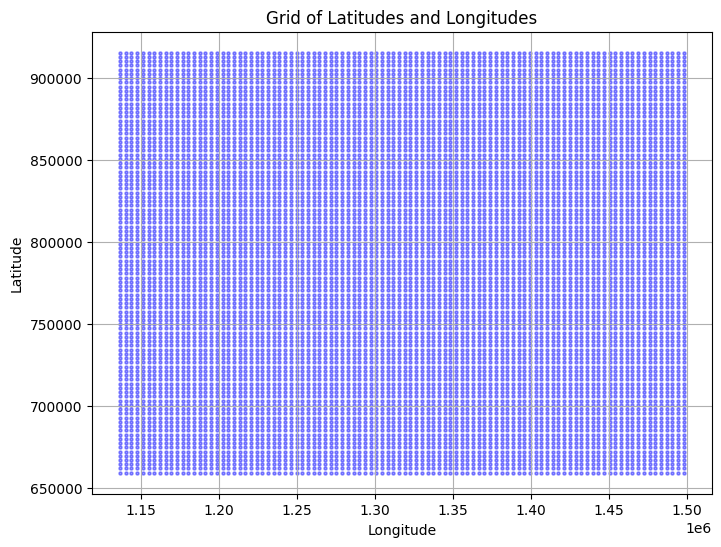

In [ ]:
import numpy as np

# Define the extent of your study area
minx, miny, maxx, maxy = 1136606.0, 659257.0, 1497934.0, 915096  # Replace with above values

# Define the number of grid points (adjust as needed)
num_points_x = 100  # Number of points in the x-direction
num_points_y = 100  # Number of points in the y-direction

# Create a grid of latitudes and longitudes within the extent
latitudes = np.linspace(miny, maxy, num_points_y)
longitudes = np.linspace(minx, maxx, num_points_x)
grid_lat, grid_lon = np.meshgrid(latitudes, longitudes)

# Display the grid dimensions
print("Grid shape:", grid_lat.shape, grid_lon.shape)

# Optionally, visualize the grid points (scatter plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(grid_lon, grid_lat, s=5, color='blue', alpha = 0.4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Grid of Latitudes and Longitudes')
plt.grid(True)
plt.show()

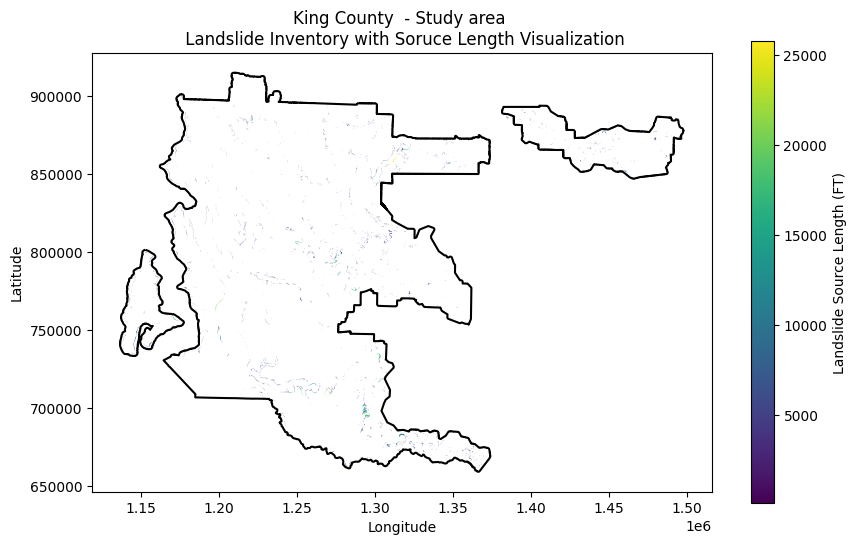

In [7]:
# Select columns of interest (e.g., area and volume)

columns_of_interest_s = ['OBJECTID', 'Shape_Leng', 'Shape_Area', 'LANDSLIDE_', 'geometry']
source_lite = source[columns_of_interest_s]

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))
study_area.boundary.plot(ax=ax, color = 'k')
source_lite.plot(ax=ax, column='Shape_Leng', legend=True, cmap='viridis', legend_kwds={'label': "Landslide Source Length (FT)"})
# grid
# plt.scatter(grid_lon, grid_lat, s=5, color='blue', alpha=0.4)
plt.title('King County  - Study area \n Landslide Inventory with Soruce Length Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
!pip install rasterio

In [ ]:
geometries = np.array(source['geometry'])
average_coords = []
for geom in geometries:
    # Convert geometry to WKT format
    wkt_representation = dumps(geom)

    # Extract the coordinates from the WKT polygon
    coordinates = re.findall(r'\d+\.\d+\s\d+\.\d+', wkt_representation)
    coordinates = [tuple(map(float, coord.split())) for coord in coordinates]

    # Print the extracted coordinates
    average_coords.append([np.mean(coordinates[0]),np.mean(coordinates[1])])

In [ ]:
from pyproj import CRS

source_crs = CRS.from_epsg(3857)

from pyproj import Proj, transform

# Define the source and target coordinate reference systems
source_crs = Proj(source_crs)  # Replace 'insert_source_CRS_here' with your actual source CRS
target_crs = Proj(proj='latlong', datum='WGS84')  # Assuming the target CRS is WGS84

# Convert each pair of coordinates from source CRS to target CRS (latitude and longitude)
lon_lat_coords = [transform(source_crs, target_crs, x, y) for x, y in coordinates]

print(lon_lat_coords)

<ipython-input-61-56fc0d145eb8>:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_lat_coords = [transform(source_crs, target_crs, x, y) for x, y in coordinates]


[(10.867717119605658, 8.007436335952331), (10.867629393503695, 8.007503904033374), (10.86739545869389, 8.007629384480184), (10.86719076299387, 8.007880340914294), (10.867132280387995, 8.0081313015373), (10.866976320923921, 8.008324349735737), (10.866810615089921, 8.008517393499135), (10.866791122350064, 8.008720092827039), (10.866420720816043, 8.008903485094931), (10.86617703963631, 8.009038616415452), (10.865952851196434, 8.009193054637434), (10.865650683024523, 8.009357139754712), (10.865436240954574, 8.009453665746575), (10.865143819152589, 8.009617750758839), (10.864948874208803, 8.009714276688918), (10.86483190461075, 8.009801146965966), (10.864667369920209, 8.009741302034094), (10.864604987889102, 8.009605397801007), (10.864467744788882, 8.009549800799103), (10.864349218052517, 8.009512737574791), (10.864224449603999, 8.009555977278909), (10.86417454222459, 8.009617750758839), (10.864168304898742, 8.009710415304673), (10.864162067572892, 8.009778365237601), (10.864143351209037, 8

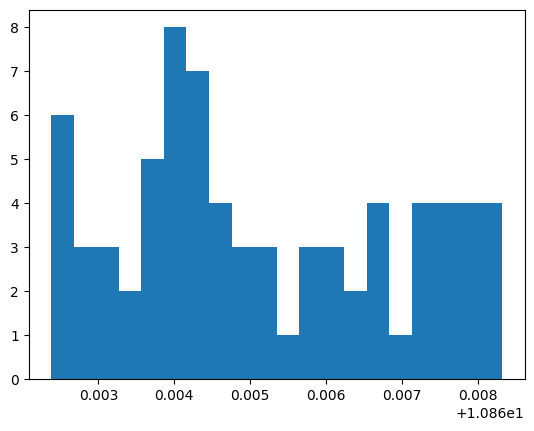

(array([ 5.,  2.,  2.,  2.,  1.,  1.,  2.,  2.,  1.,  2.,  2.,  2.,  5.,
         7.,  6.,  3.,  4., 11., 10.,  4.]),
 array([8.00728027, 8.00745129, 8.00762231, 8.00779334, 8.00796436,
        8.00813539, 8.00830641, 8.00847743, 8.00864846, 8.00881948,
        8.0089905 , 8.00916153, 8.00933255, 8.00950357, 8.0096746 ,
        8.00984562, 8.01001664, 8.01018767, 8.01035869, 8.01052971,
        8.01070074]),
 <BarContainer object of 20 artists>)

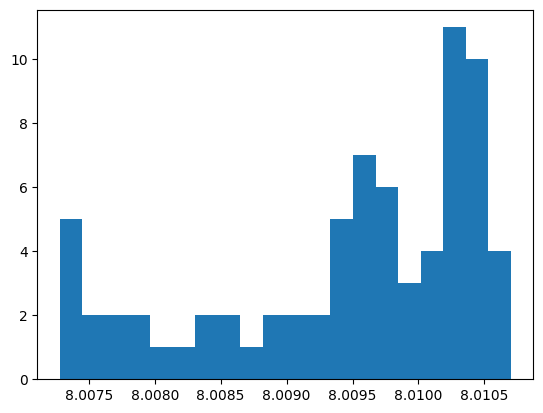

In [ ]:
coords = (lon_lat_coords)
lat = [t[0] for t in coords]
lon = [t[1] for t in coords]
plt.hist(lat, bins = 20)
plt.show()
plt.hist(lon, bins = 20)

In [ ]:
# extract coordinates and source area:
area = np.array(source['Shape_Area'])
id = np.array(source['LANDSLIDE_'])


In [ ]:
inventory_df = pd.DataFrame({
    'id': id,
    'coords': coords,
    'area': area
})

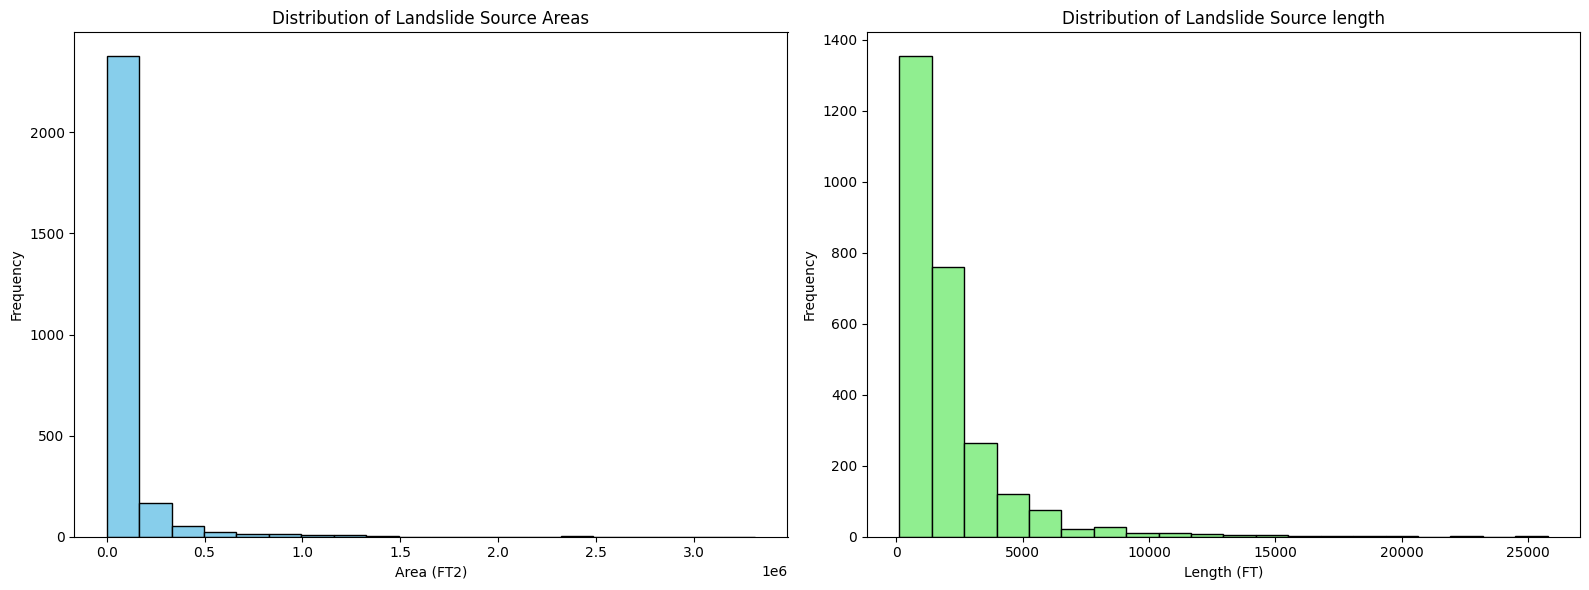

In [ ]:
# Plotting histograms
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram for landslide source areas
axes[0].hist(source_lite['Shape_Area'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Landslide Source Areas')
axes[0].set_xlabel('Area (FT2)')
axes[0].set_ylabel('Frequency')

# Histogram for landslide source length
axes[1].hist(source_lite['Shape_Leng'], bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribution of Landslide Source length')
axes[1].set_xlabel('Length (FT)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Deposit

In [ ]:
# Read the shapefile using geopandas
deposit = gpd.read_file(main_path + '/inventory/landslide_deposits_export.shp')

print(deposit.columns)
print(deposit.shape)
print(deposit.info())

# Sanity check
deposit.head()

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'LANDSLIDE_', 'MATERIAL',
       'MOVEMENT', 'MOVE_CODE', 'CONFIDENCE', 'RELATIVE_A', 'YEAR_MOVE',
       'FIELD_VERI', 'SLOPE_DEG', 'HS_HEIGHT_', 'FAIL_DEPTH', 'MVMT_AZIMU',
       'VOLUME_FT3', 'AVG_SCARP_', 'LS_NAME', 'COMMENTS', 'geometry'],
      dtype='object')
(2641, 20)
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2641 entries, 0 to 2640
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    2641 non-null   int64   
 1   Shape_Leng  2641 non-null   float64 
 2   Shape_Area  2641 non-null   float64 
 3   LANDSLIDE_  2641 non-null   int64   
 4   MATERIAL    2641 non-null   object  
 5   MOVEMENT    2641 non-null   object  
 6   MOVE_CODE   2641 non-null   object  
 7   CONFIDENCE  2641 non-null   object  
 8   RELATIVE_A  2641 non-null   object  
 9   YEAR_MOVE   61 non-null     object  
 10  FIELD_VERI  2641 non-null   object  
 11  SLOPE_DE

,OBJECTID,Shape_Leng,Shape_Area,LANDSLIDE_,MATERIAL,MOVEMENT,MOVE_CODE,CONFIDENCE,RELATIVE_A,YEAR_MOVE,FIELD_VERI,SLOPE_DEG,HS_HEIGHT_,FAIL_DEPTH,MVMT_AZIMU,VOLUME_FT3,AVG_SCARP_,LS_NAME,COMMENTS,geometry
0,1,3796.286693,531934.562792,5600,Earth or debris,C,ES-R+EFL,moderate,PH,None,No,31,72,62,270.0,3.297994e+07,112,None,<Null>,"POLYGON ((1175849.442 900039.466, 1175842.760 ..."
1,2,568.419361,13973.308516,5601,Earth or debris,FL,EFL,low,PH,None,No,31,40,34,270.0,4.750925e+05,0,None,<Null>,"POLYGON ((1175888.516 899946.858, 1175898.932 ..."
2,3,767.721166,25699.961862,5602,Earth or debris,FL,EFL,low,PH,None,No,28,28,25,225.0,6.424990e+05,0,None,<Null>,"POLYGON ((1176070.807 899783.664, 1176052.578 ..."
3,4,1383.062457,94054.007176,5603,Earth or debris,C,ES-R+EFL,low,PH,None,No,32,45,38,292.5,3.574052e+06,0,None,<Null>,"POLYGON ((1175942.335 899602.240, 1175949.362 ..."
4,5,1316.285970,90517.371084,5604,Earth or debris,FL,EFL,moderate,PH,None,No,32,33,28,315.0,2.534486e+06,0,None,<Null>,"POLYGON ((1175849.125 899275.868, 1175856.963 ..."


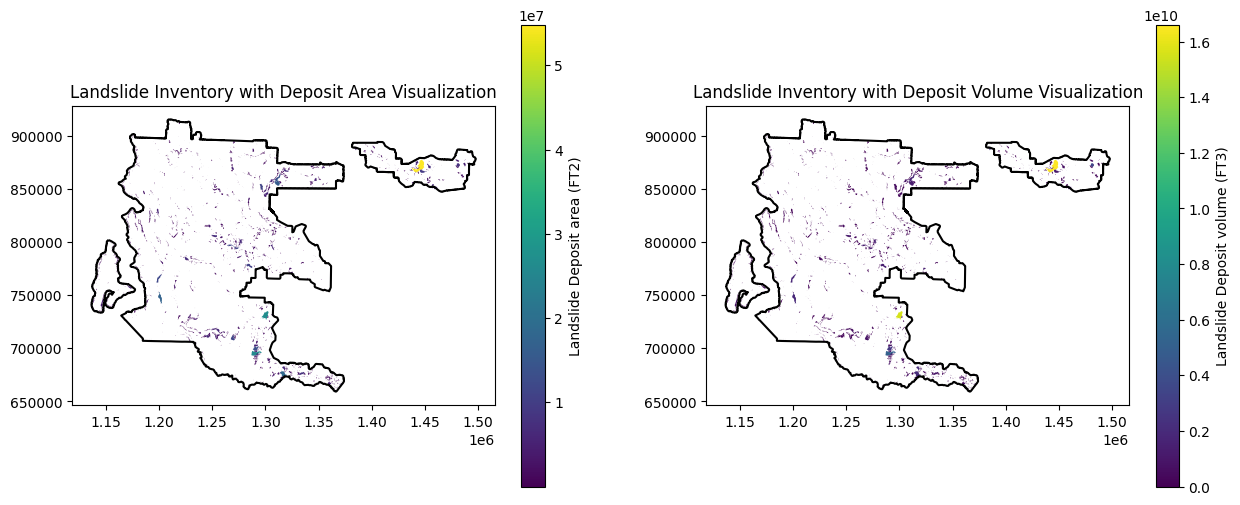

In [ ]:
# Select columns of interest (e.g., area and volume)
columns_of_interest_d = ['Shape_Area', 'LANDSLIDE_', 'CONFIDENCE', 'MATERIAL', 'SLOPE_DEG', 'HS_HEIGHT_', 'FAIL_DEPTH','VOLUME_FT3', 'geometry']
deposit_lite = deposit[columns_of_interest_d]

# Plotting the data
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
study_area.boundary.plot(ax=axes[0], color = 'k')
deposit_lite.plot(ax=axes[0], column='Shape_Area', legend=True, cmap='viridis', legend_kwds={'label': "Landslide Deposit area (FT2)"})
plt.title('King County - Study Area')
axes[0].set_title('Landslide Inventory with Deposit Area Visualization')

study_area.boundary.plot(ax=axes[1], color = 'k')
deposit_lite.plot(ax=axes[1], column='VOLUME_FT3', legend=True, cmap='viridis', legend_kwds={'label': "Landslide Deposit volume (FT3)"})
axes[1].set_title('Landslide Inventory with Deposit Volume Visualization')

# plt.tight_layout()
plt.show()

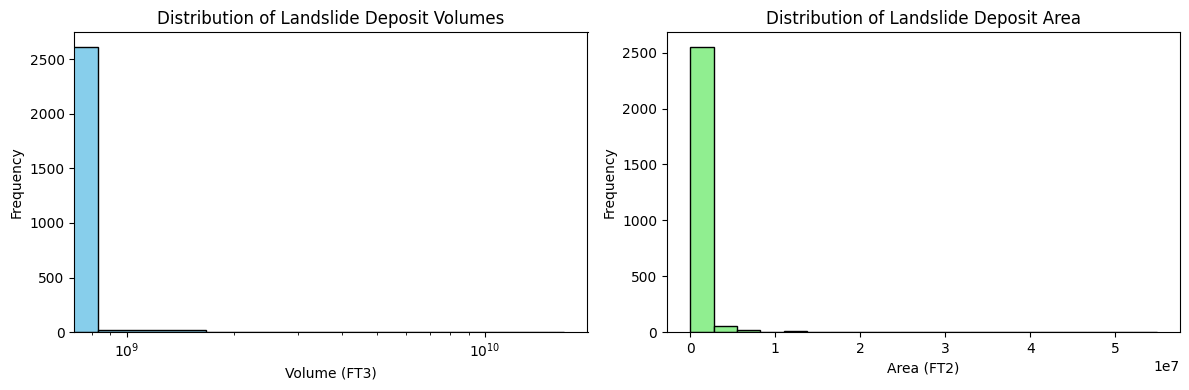

In [ ]:
# Plotting histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram for landslide volumes
axes[0].hist(deposit_lite['VOLUME_FT3'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Landslide Deposit Volumes')
axes[0].set_xlabel('Volume (FT3)')
axes[0].set_ylabel('Frequency')
axes[0].set_xscale('log')

# Histogram for landslide slope degree
axes[1].hist(deposit_lite['Shape_Area'], bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribution of Landslide Deposit Area')
axes[1].set_xlabel('Area (FT2)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Merge Data frames

In [ ]:
# Merge data on "LANDSLIDE_" column. It should match with both source and deposit.
# For source we are interested in columns_of_interest = ['Shape_Area','Shape_Leng']
# For deposit we are interested in columns_of_interest = ['Shape_Area', 'SLOPE_DEG', 'HS_HEIGHT_', 'FAIL_DEPTH','VOLUME_FT3']

# Keeping source geometry as geographic unit
columns_of_interest_d = ['Shape_Area', 'LANDSLIDE_', 'CONFIDENCE', 'MATERIAL', 'SLOPE_DEG', 'HS_HEIGHT_', 'FAIL_DEPTH','VOLUME_FT3']
deposit_lite = deposit[columns_of_interest_d]

inventory = source_lite.merge(deposit_lite, on = 'LANDSLIDE_', how = 'left')
print(inventory.shape)
print(inventory.info())

(2670, 12)
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2670 entries, 0 to 2669
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      2670 non-null   int64   
 1   Shape_Leng    2670 non-null   float64 
 2   Shape_Area_x  2670 non-null   float64 
 3   LANDSLIDE_    2670 non-null   int64   
 4   geometry      2670 non-null   geometry
 5   Shape_Area_y  2670 non-null   float64 
 6   CONFIDENCE    2670 non-null   object  
 7   MATERIAL      2670 non-null   object  
 8   SLOPE_DEG     2670 non-null   int64   
 9   HS_HEIGHT_    2670 non-null   int64   
 10  FAIL_DEPTH    2670 non-null   int64   
 11  VOLUME_FT3    2670 non-null   float64 
dtypes: float64(4), geometry(1), int64(5), object(2)
memory usage: 271.2+ KB
None


In [ ]:
inventory.head()

,OBJECTID,Shape_Leng,Shape_Area_x,LANDSLIDE_,geometry,Shape_Area_y,CONFIDENCE,MATERIAL,SLOPE_DEG,HS_HEIGHT_,FAIL_DEPTH,VOLUME_FT3
0,1,3851.588931,147260.070502,5600,"POLYGON ((1175895.407 901572.922, 1175950.408 ...",531934.562792,moderate,Earth or debris,31,72,62,3.297994e+07
1,2,478.577643,7375.893616,5601,"POLYGON ((1175850.769 899952.492, 1175859.171 ...",13973.308516,low,Earth or debris,31,40,34,4.750925e+05
2,3,621.878585,9097.112403,5602,"POLYGON ((1175964.686 899854.428, 1175984.870 ...",25699.961862,low,Earth or debris,28,28,25,6.424990e+05
3,4,1187.857110,20648.173693,5603,"POLYGON ((1175963.168 899470.295, 1175991.438 ...",94054.007176,low,Earth or debris,32,45,38,3.574052e+06
4,5,1866.133373,35616.221508,5604,"POLYGON ((1175870.173 899170.666, 1175868.971 ...",90517.371084,moderate,Earth or debris,32,33,28,2.534486e+06


In [ ]:
inventory = inventory.rename(columns={'Shape_Leng':'soruce_length', 'Shape_Area_x':'source_area', 'LANDSLIDE_':'landslide_ID','geometry_x':'geometry', 'Shape_Area_y':'deposit_area', 'HS_HEIGHT_':'HS_HEIGHT', 'geometry_y':'geom_deposit'})
inventory.columns

Index(['OBJECTID', 'soruce_length', 'source_area', 'landslide_ID', 'geometry',
       'deposit_area', 'CONFIDENCE', 'MATERIAL', 'SLOPE_DEG', 'HS_HEIGHT',
       'FAIL_DEPTH', 'VOLUME_FT3'],
      dtype='object')

In [ ]:
inventory_gdf = gpd.GeoDataFrame(inventory, geometry = 'geometry')
print(inventory_gdf.geometry)

0       POLYGON ((1175895.407 901572.922, 1175950.408 ...
1       POLYGON ((1175850.769 899952.492, 1175859.171 ...
2       POLYGON ((1175964.686 899854.428, 1175984.870 ...
3       POLYGON ((1175963.168 899470.295, 1175991.438 ...
4       POLYGON ((1175870.173 899170.666, 1175868.971 ...
                              ...                        
2665    POLYGON ((1270173.686 772825.701, 1270167.680 ...
2666    POLYGON ((1270200.477 773672.144, 1270182.437 ...
2667    POLYGON ((1223576.408 848503.604, 1223576.922 ...
2668    POLYGON ((1209815.747 894111.856, 1209708.976 ...
2669    POLYGON ((1209788.736 894299.703, 1209778.970 ...
Name: geometry, Length: 2670, dtype: geometry


In [ ]:
# saving merged data
inventory.to_csv(main_path + '/inventory/inventory_merged.csv')
inventory_gdf.to_file(main_path + '/inventory/inventory_gdf.gpkg', driver = 'GPKG')

In [ ]:
# Sanity check:
inventory_gdf.head()

,OBJECTID,soruce_length,source_area,landslide_ID,geometry,deposit_area,CONFIDENCE,MATERIAL,SLOPE_DEG,HS_HEIGHT,FAIL_DEPTH,VOLUME_FT3
0,1,3851.588931,147260.070502,5600,"POLYGON ((1175895.407 901572.922, 1175950.408 ...",531934.562792,moderate,Earth or debris,31,72,62,3.297994e+07
1,2,478.577643,7375.893616,5601,"POLYGON ((1175850.769 899952.492, 1175859.171 ...",13973.308516,low,Earth or debris,31,40,34,4.750925e+05
2,3,621.878585,9097.112403,5602,"POLYGON ((1175964.686 899854.428, 1175984.870 ...",25699.961862,low,Earth or debris,28,28,25,6.424990e+05
3,4,1187.857110,20648.173693,5603,"POLYGON ((1175963.168 899470.295, 1175991.438 ...",94054.007176,low,Earth or debris,32,45,38,3.574052e+06
4,5,1866.133373,35616.221508,5604,"POLYGON ((1175870.173 899170.666, 1175868.971 ...",90517.371084,moderate,Earth or debris,32,33,28,2.534486e+06
